In [1]:
import os
import random
import numpy as np
import pandas as pd 

import cv2
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt

In [2]:
# looking for 5 random images in train set 
train_dir = "./data/train_v2/"
train_size = len(os.listdir(train_dir)) 
random_index = random.randint(0, train_size) 
print(os.listdir(train_dir)[random_index : random_index + 5]) 

['7d966d8e5.jpg', '5e417a4d6.jpg', 'f1a1e2b33.jpg', '0f1b431ef.jpg', '0aa25e356.jpg']


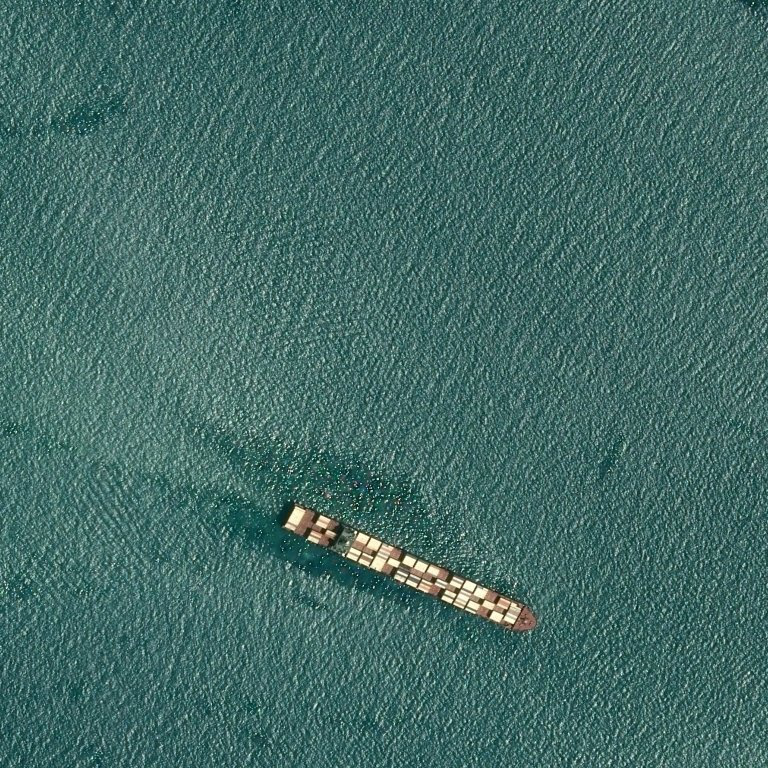

In [3]:
# sample image
Image.open("./data/train_v2/00ce2c1c0.jpg")

<p> Note: Good Example. <br> TO-DO:
    <ol> <li>
        Detect the container ship with segmentation model.</li>
        <li>create bounding box around prediction</li></ol></p>

In [4]:
test_size = len(os.listdir("./data/test_v2/")) 
print("\033[44;1mTrain Size\033[0m", "\033[0;37;94m {}\033[0m".format(train_size), end=" ")
print("\033[44;1mTest Size\033[0m", "\033[0;37;94m {}".format(test_size))

Train Size  192556 Test Size  15606


In [5]:
# loading the annotation data 
annotation = pd.read_csv("./data/train_ship_segmentations_v2.csv") 

print("total records", annotation.shape) 
annotation.head()

total records (231723, 2)


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [6]:
# data contains images without ships, check to see the amount of data without ships 

# an important factor, helps the model identify background and desired object; the ratio of images with no ships to images with ships can be tweaked based on model performance.
annotation['num_of_ships'] = annotation['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0) 

unique_img_ids = annotation.groupby('ImageId').agg({'num_of_ships': 'sum'}).reset_index()
unique_img_ids['is_ship'] = unique_img_ids['num_of_ships'].map(lambda x: 1.0 if x>0 else 0.0)

print("Number of images without SHIPS >", unique_img_ids['is_ship'].value_counts()[0])
print("Number of images with SHIPS >", unique_img_ids['is_ship'].value_counts()[1])

Number of images without SHIPS > 150000
Number of images with SHIPS > 42556


In [7]:
print(f"Count of images with number (0, 1, 2 etc.) of ships \n{unique_img_ids['num_of_ships'].value_counts()}")

Count of images with number (0, 1, 2 etc.) of ships 
0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: num_of_ships, dtype: int64


In [8]:
# Function to encode mask >> Run Length Encoding(rle) 
def rle_decode(mask_rle, IMG_SIZE = (768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(IMG_SIZE[0]*IMG_SIZE[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(IMG_SIZE).T

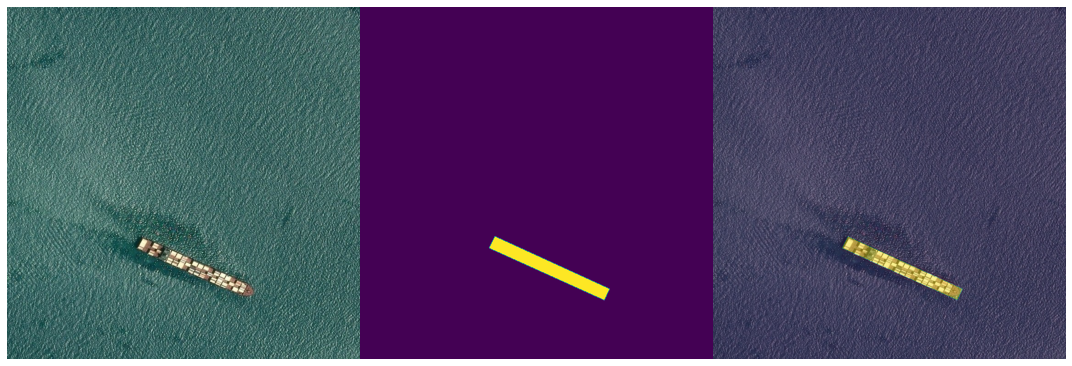

In [9]:
ImageId = '00ce2c1c0.jpg'

img = io.imread("./data/train_v2/00ce2c1c0.jpg")
img_masks = annotation.loc[annotation['ImageId'] == ImageId, 'EncodedPixels'].tolist()

# Take the individual ship masks and create a single mask array for all ships
all_masks = np.zeros((768, 768))
for mask in img_masks:
    all_masks += rle_decode(mask, (768, 768))
    

fig, axarr = plt.subplots(1, 3, figsize=(15, 40))
axarr[0].axis('off')
axarr[1].axis('off')
axarr[2].axis('off')
axarr[0].imshow(img)
axarr[1].imshow(all_masks)
axarr[2].imshow(img)
axarr[2].imshow(all_masks, alpha=0.4)
plt.tight_layout(h_pad=0.1, w_pad=0.1)
plt.show()

In [10]:
# diemensions of the sample image
img.shape

(768, 768, 3)

In [15]:
imgs_with_ships = unique_img_ids.ImageId.loc[unique_img_ids["num_of_ships"] > 0].tolist()

with open("images_with_ships.txt", "w") as output:
    output.write(str(imgs_with_ships))